<center> <h1> Freesound Audio Tagging </h1> </center>

# 6. Error Analysis

### Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import IPython
import tensorflow as tf

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  Flatten, Dense
from sklearn.metrics import label_ranking_average_precision_score
from tensorflow.keras.metrics import Metric

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Ref: https://stackoverflow.com/questions/55081911/tensorflow-2-0-0-alpha0-tf-logging-set-verbosity
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [5]:
#Setting the figure size for all plots: https://stackoverflow.com/questions/7125009/how-to-change-legend-size-with-matplotlib-pyplot
%matplotlib inline

params = {'figure.figsize' : (16, 9),
          'legend.fontsize': 16,
          'legend.handlelength': 2,
          'axes.titlesize' : 'large'}

plt.rcParams.update(params)

In [6]:
# Config class is used to share global parameters across various functions
class Config():
    def __init__(self, sampling_rate, n_classes=80):
        self.sampling_rate=sampling_rate
        self.n_classes=n_classes
        self.stft_window_seconds=0.025
        self.stft_hop_seconds=0.010
        self.mel_bands=96
        self.mel_min_hz=20
        self.mel_max_hz=20000
        self.mel_log_offset=0.001
        self.example_window_seconds=1.0
        self.example_hop_seconds=0.5

In [7]:
# All input clips use a 44.1 kHz sample rate.
SAMPLE_RATE = 44100
config = Config(SAMPLE_RATE)

### Prediction on train data using the final model

In [10]:
df_train = pd.read_csv('df_train_curated_with_durations.csv')
TRAIN_FILES_DIRECTORY = r'F:\Jupyter_Notebook\AAIC\Assignments\Case_Study_2_Freesound_Audio_Tagging\train_data'

In [11]:
def clip_to_waveform(clip, clip_dir=None):
    """
    Description -> Decodes a WAV clip into a waveform tensor where the values lie in [-1, +1]
    Inputs->
        clip -> .wav file eg. file1.wav
        clip_dir -> Parent folder in which the above clips is stored, for eg., "TRAIN_DIR"
    Output -> Tensor corrsponding to the clip with all values between -1 to 1
    """
    clip_path = tf.strings.join([clip_dir, clip], separator=os.sep)
    clip_data = tf.io.read_file(clip_path)
    waveform, sr = tf.audio.decode_wav(clip_data)
    return tf.squeeze(waveform)

def clip_to_log_mel_examples(clip, clip_dir=None):
    """
    Description -> Decodes a WAV clip into a batch of log mel spectrum examples
    This function takes the given .wav file, gets it tensor representation, converts it into spectrogram using short-time
    Fourier transform, then converts the spectrogram into log mel spectrogram, finally, it divides it into various windows
    and returns all the windows in a 3-channel format
    
    Inputs->
        clip -> .wav file eg. file1.wav
        clip_dir -> Parent folder in which the above clips is stored, for eg., "TRAIN_DIR"
        
    Output -> Log mel spectrogram windowed features
    """
    # Decode WAV clip into waveform tensor.
    waveform = clip_to_waveform(clip, clip_dir=clip_dir)

    # Convert waveform into spectrogram using a Short-Time Fourier Transform.
    # Note that tf.signal.stft() uses a periodic Hann window by default.
    window_length_samples = int(round(config.sampling_rate * config.stft_window_seconds))
    hop_length_samples = int(round(config.sampling_rate * config.stft_hop_seconds))
    fft_length = 2 ** int(np.ceil(np.log2(window_length_samples)))
    
    magnitude_spectrogram = tf.math.abs(tf.signal.stft(signals=waveform,
                                                       frame_length=window_length_samples,
                                                       frame_step=hop_length_samples,
                                                       fft_length=fft_length))

    # Convert spectrogram into log mel spectrogram.
    num_spectrogram_bins = fft_length // 2 + 1
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(num_mel_bins=config.mel_bands,
                                                                        num_spectrogram_bins=num_spectrogram_bins,
                                                                        sample_rate=config.sampling_rate,
                                                                        lower_edge_hertz=config.mel_min_hz,
                                                                        upper_edge_hertz=config.mel_max_hz)
    mel_spectrogram = tf.matmul(magnitude_spectrogram, linear_to_mel_weight_matrix)
    log_mel_spectrogram = tf.math.log(mel_spectrogram + config.mel_log_offset)

    # Frame log mel spectrogram into examples.
    spectrogram_sr = 1 / config.stft_hop_seconds
    example_window_length_samples = int(round(spectrogram_sr * config.example_window_seconds))
    example_hop_length_samples = int(round(spectrogram_sr * config.example_hop_seconds))
    features = tf.signal.frame(signal=log_mel_spectrogram,
                               frame_length=example_window_length_samples,
                               frame_step=example_hop_length_samples,
                               pad_end=True,
                               pad_value=0.0,
                               axis=0)
    
    # Converting mono channel to 3 channels
    features=tf.stack([features,features,features], axis=-1)
    return features

def record_to_labeled_log_mel_examples(csv_record,
                                       clip_dir=None,
                                       label_class_index_table=None,
                                       num_classes=None):
    """
    Description -> Creates a batch of log mel spectrum examples from a training record.

    Inputs ->
    csv_record: a line from a training CSV file downloaded from Kaggle
    clip_dir: path to a directory containing clips referenced by csv_record
    label_class_index_table: a lookup table that represents the class map
    num_classes: number of classes in the class map

    Output ->
    features: Tensor containing a batch of log mel spectrum examples
    labels: Tensor containing corresponding labels in 1-hot format
    
    """
    # clip is the filename such as "filename1.wav"
    # labels_str is the string of all labels corresponding to that filename eg., "bike,vroom,accelarate"
    [clip, labels_str] = tf.io.decode_csv(csv_record, record_defaults=[[''],['']])
    
    # features are the windowed log mel spectrogram examples
    features = clip_to_log_mel_examples(clip, clip_dir=clip_dir)
    
    # num_examples are the total number of windows
    num_examples = tf.shape(features)[0]
    
    # We split all the labels by comma
    clip_labels = tf.strings.split([labels_str], sep=',').values
    
    # Obtain the corresponding indices from the lookup table
    class_indices = label_class_index_table.lookup(clip_labels)
    
    # One Hot Encode the class_indices
    label_onehots = tf.one_hot(indices=class_indices, depth=num_classes)
    label_multihot = tf.math.reduce_max(label_onehots, axis=[0], keepdims=False)
    
    # Adjust the dimensionality of the OHE labels
    labels = tf.tile([label_multihot], [num_examples, 1])

    return features, labels

def get_class_map(class_map_path):
    """
    Description -> Constructs a class label lookup table from a class map
    
    Input ->
    class_map_path: Path to the class_map.csv file which contains the mapping of each unqiue class label to an integer from 0-79
    
    Output ->
    label_class_index_table: Lookup table mapping each class label to a unique integer
    num_classes: Total number of unique classes
    """
    label_class_index_table = tf.lookup.StaticHashTable(tf.lookup.TextFileInitializer(filename=class_map_path,
                                                                                      key_dtype=tf.string,
                                                                                      key_index=1,
                                                                                      value_dtype=tf.int32,
                                                                                      value_index=0,
                                                                                      delimiter=','),
                                                        default_value=-1)
    num_classes = len(open(class_map_path).readlines())
    return label_class_index_table, num_classes

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_csv_path = 'train_curated.csv'
class_map_path = 'class_map.csv'
label_class_index_table, num_classes = get_class_map(class_map_path)
train_dataset = tf.data.TextLineDataset(train_csv_path)
train_dataset = train_dataset.skip(1)
train_dataset = train_dataset.map(lambda x: record_to_labeled_log_mel_examples(x,
                                                                               clip_dir=TRAIN_FILES_DIRECTORY,
                                                                               label_class_index_table=label_class_index_table,
                                                                               num_classes=num_classes),
                                  num_parallel_calls=AUTOTUNE)

### Defining the scoring metric: LWLRAP

In [13]:
# Reference implementation from: https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8
def _lwlrap_sklearn(truth, scores):
    '''
    Description -> Return the Label Weighted Label Ranking Average Precision (LWLRAP) of the given true and predicted
    class labels
    
    Inputs ->
    truth: OHE Vector of truth class label
    scores: NumPy array of predictions
    
    Output -> LWLRAP score
    '''
    sample_weight = np.sum(truth > 0, axis=1)
    nonzero_weight_sample_indices = np.flatnonzero(sample_weight > 0)
    overall_lwlrap = label_ranking_average_precision_score(
        truth[nonzero_weight_sample_indices, :] > 0, 
        scores[nonzero_weight_sample_indices, :], 
        sample_weight=sample_weight[nonzero_weight_sample_indices])
    return overall_lwlrap


def _one_sample_positive_class_precisions(example):
    y_true, y_pred = example
    retrieved_classes = tf.argsort(y_pred, direction='DESCENDING')
    class_rankings = tf.argsort(retrieved_classes)
    retrieved_class_true = tf.gather(y_true, retrieved_classes)
    retrieved_cumulative_hits = tf.math.cumsum(tf.cast(retrieved_class_true, tf.float32))

    idx = tf.where(y_true)[:, 0]
    i = tf.boolean_mask(class_rankings, y_true)
    r = tf.gather(retrieved_cumulative_hits, i)
    c = 1 + tf.cast(i, tf.float32)
    precisions = r / c
    dense = tf.scatter_nd(idx[:, None], precisions, [y_pred.shape[0]])
    return dense

class LWLRAP(Metric):
    def __init__(self, num_classes, name='lwlrap'):
        super().__init__(name=name)

        self._precisions = self.add_weight(
            name='per_class_cumulative_precision',
            shape=[num_classes],
            initializer='zeros')

        self._counts = self.add_weight(
            name='per_class_cumulative_count',
            shape=[num_classes],
            initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        precisions = tf.map_fn(
            fn=_one_sample_positive_class_precisions,
            elems=(y_true, y_pred),
            dtype=(tf.float32))

        increments = tf.cast(precisions > 0, tf.float32)
        total_increments = tf.reduce_sum(increments, axis=0)
        total_precisions = tf.reduce_sum(precisions, axis=0)

        self._precisions.assign_add(total_precisions)
        self._counts.assign_add(total_increments)        

    def result(self):
        per_class_lwlrap = self._precisions / tf.maximum(self._counts, 1.0)
        per_class_weight = self._counts / tf.reduce_sum(self._counts)
        overall_lwlrap = tf.reduce_sum(per_class_lwlrap * per_class_weight)
        return overall_lwlrap

    def reset_states(self):
        self._precisions.assign(self._precisions * 0)
        self._counts.assign(self._counts * 0)

### Defining the final model architecture

In [14]:
# The model used here is the MobileNet by Google
# Ref: https://stackoverflow.com/questions/41668813/how-to-add-and-remove-new-layers-in-keras-after-loading-weights
def get_2dcnn_model(weights_path=None):
    '''
    Description -> Return the 2D CNN Model
    
    Input ->
    weights_path (optional): Path to the best model weights (used at testing time)
    
    Output -> Model instance
    
    It returns the compiled model which will be used for training if no "weights_path" is supplied, else, it returns the model
    with best weights found during training which will be used during testing phase
    '''
    source_model = MobileNet(include_top=False, input_shape=(100, 96, 3))
    x = Flatten()(source_model.layers[-1].output)
    out = Dense(80)(x)
    model = Model(inputs=source_model.input, outputs=out)
    if not weights_path:
        model.compile(optimizer='adam',
                      loss=tf.nn.sigmoid_cross_entropy_with_logits,
                      metrics=[LWLRAP(80)])
    else:
        model.load_weights(weights_path)
        
    return model

In [15]:
model = get_2dcnn_model(weights_path='best.h5')
predictions=model.predict(train_dataset, verbose=1)

4970/4970 [==============================] - 272s 55ms/step


### Obtaining true class labels

In [16]:
def get_actual_class_labels(csv_record,
                            clip_dir=None,
                            label_class_index_table=None,
                            num_classes=None):
    """
    Returns the actual class labels encoded in one-hot format

    Inputs ->
    csv_record: a line from a training CSV file downloaded from Kaggle
    clip_dir: path to a directory containing clips referenced by csv_record.
    label_class_index_table: a lookup table that represents the class map
    num_classes: number of classes in the class map

    Output ->
    label_multihot: Tensor containing corresponding labels in 1-hot format
    """
    [clip, labels_str] = tf.io.decode_csv(csv_record, record_defaults=[[''],['']])
    clip_labels = tf.strings.split([labels_str], sep=',').values
    class_indices = label_class_index_table.lookup(clip_labels)
    label_onehots = tf.one_hot(indices=class_indices, depth=num_classes)
    label_multihot = tf.math.reduce_max(label_onehots, axis=[0], keepdims=False)
    return label_multihot

In [17]:
y_actual = tf.data.TextLineDataset(train_csv_path)
y_actual = y_actual.skip(1)
y_actual = y_actual.map(lambda x: get_actual_class_labels(x,
                                                          clip_dir=TRAIN_FILES_DIRECTORY,
                                                          label_class_index_table=label_class_index_table,
                                                          num_classes=config.n_classes),
                        num_parallel_calls=AUTOTUNE)

### Obtaining the final predictions

This is done by averaging all the frames of a particular clip (the same way it was done for test data)

In [18]:
# Each clip is windowed into several examples of varying sizes which we unbatch and again batch into uniform sized batches
# But, we need to keep track of the number of windows for each example as these will be helpful in the end when we will average
# the outcomes of all the examples
clip_sizes=[None]*len(os.listdir(TRAIN_FILES_DIRECTORY))
i=0
for clip in train_dataset:
    clip_sizes[i]=(tf.shape(clip[1])[0]).numpy()
    i+=1

In [21]:
def averaged_prediction(label_idx, start_idx):
    '''
    Description ->
    The model predicts the probabilities for each of the 80 classes for each window, but, for final predictions we need to
    combine the predictions for all windows of a given clip so that we get y_pred to be of the same size as number of clips
    in the test dataset
    
    Inputs ->
    label_idx: Index corr. to the current clip being processed, this is used to obtain the total number of windows in the given
    clip using the earlier computed "clip_sizes" list
    
    start_idx: Index of the first window in the predictions from which the averaging has to start for the given clip
    The average is computed from start_idx upto (start_idx + clip_size) which acts like end_idx
    
    Output ->
    end_idx: The index of the last window of the given clip (which acts like the starting index of the next clip)
    avg: Averaged predictions of all windows corr. to a particular clip from start_idx till end_idx
    '''
    size=clip_sizes[label_idx]
    end_idx=start_idx+size
    df=predictions[start_idx:end_idx]
    avg=np.average(df, axis=0)
    return end_idx, avg

In [22]:
train_dataset_size=len(clip_sizes)
predictions_final=np.zeros((train_dataset_size, 80))
start_idx=0
for label_idx in range(train_dataset_size):
    start_idx, predictions_final[label_idx] = averaged_prediction(label_idx, start_idx)

In [23]:
predictions = predictions_final

### Calculating the sigmoid cross entropy loss for each clip

In [24]:
# Converting TF datatype to Numpy format
y_true = [None]*len(clip_sizes)
i=0
for ohe_vector in y_actual:
    y_true[i] = ohe_vector.numpy()
    i+=1

In [25]:
y_true=np.array(y_true, dtype='float64')

In [26]:
losses=[0]*y_true.shape[0]
for i in range(y_true.shape[0]):
    losses[i] = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(predictions[i], y_true[i])).numpy()
df_train['loss'] = losses

### Obtaining the predicted label for each clip

In [27]:
# Obtaining the class label with the highest probability
predictions_index = np.zeros((df_train.shape[0], 1))
for i in range(df_train.shape[0]):
    predictions_index[i] = np.argmax(predictions[i])

In [28]:
#Creating a mapping between index and each of the class label, eg. {0: class_label_1, 1: class_label_2, ... 79: class_label_80}
LABELS=set()
all_labels = list(df_train['labels'])
for row in all_labels:
    for lab in row.split(r','):
        LABELS.add(lab)

LABELS=list(LABELS)
LABELS.sort()

label_dict = {}
for i, lab in enumerate(LABELS):
    label_dict[i] = lab

In [29]:
# Obtaining the Actual predicted labels from indices
predictions_label = []
for i in range(df_train.shape[0]):
    predictions_label.append(label_dict[int(predictions_index[i][0])])

In [30]:
df_train['predicted_label'] = predictions_label

In [31]:
df_train.head()

fname           labels   duration      loss  predicted_label
0  0006ae4e.wav             bark   7.039819  0.692626             bark
1  0019ef41.wav         raindrop   2.054785  0.742695             drip
2  001ec0ad.wav  finger_snapping   1.518730  0.709200  finger_snapping
3  0026c7cb.wav              run  25.530295  0.667618              run
4  0026f116.wav  finger_snapping   1.375011  0.714553  finger_snapping

In [32]:
df_train.to_csv('df_train_final.csv', index=False)

In [33]:
df_train = df_train.sort_values(by=['loss'])

## Anaylsis on loss

In [34]:
df_train['loss'].describe()

count    4970.000000
mean        0.715561
std         0.040768
min         0.510646
25%         0.695591
50%         0.717367
75%         0.736698
max         1.047204
Name: loss, dtype: float64

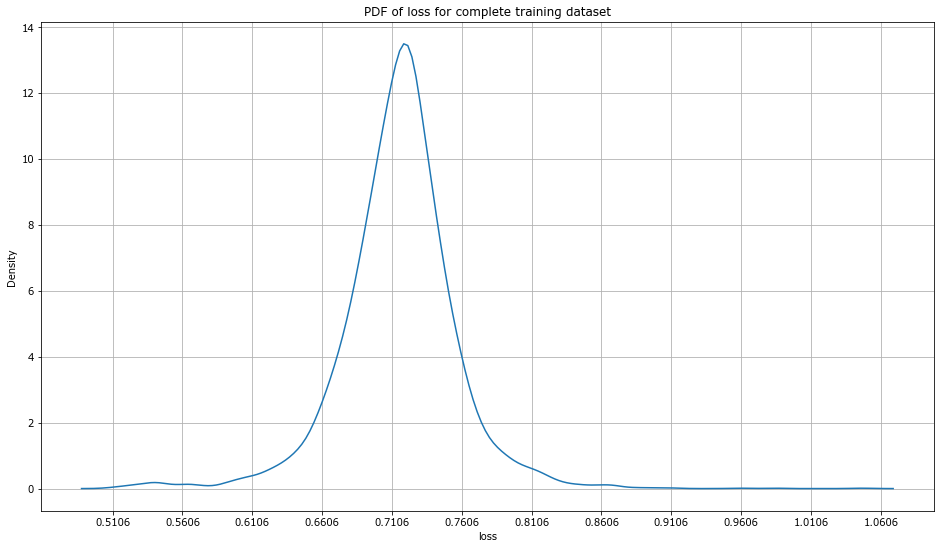

In [35]:
sns.kdeplot(df_train['loss'])
delta = 0.05
plt.title('PDF of loss for complete training dataset')
plt.xticks(np.arange(np.min(df_train['loss']), np.max(df_train['loss']) + delta, delta))
plt.grid()
plt.show()

**Observation: The distribution looks like a normal distribution with fat tails which means most of the errors are close to the average error while there are few points with quite high error**

In [36]:
losses = np.array(df_train['loss'])

In [37]:
for i in range(0, 110, 10):
    print(f"{i}th percentile = {np.round(np.percentile(losses, i), 3)}")

0th percentile = 0.511
10th percentile = 0.671
20th percentile = 0.689
30th percentile = 0.701
40th percentile = 0.71
50th percentile = 0.717
60th percentile = 0.724
70th percentile = 0.732
80th percentile = 0.742
90th percentile = 0.758
100th percentile = 1.047


### Dividing the clips into 3 categories:
1. Best Performance: Having least loss
2. Medium Performance: Having average loss 
3. Worst Performance: Having highest loss

We divide the dataframe such that each of the categories has equal number of datapoints

In [38]:
low_threshold = np.percentile(losses, 33.33)
mid_threshold = np.percentile(losses, 66.67)

In [39]:
df_best_perf  = df_train[df_train['loss'] <= low_threshold]
df_med_perf   = df_train[(df_train['loss'] > low_threshold) & (df_train['loss'] <= mid_threshold)]
df_worst_perf = df_train[df_train['loss'] > mid_threshold]

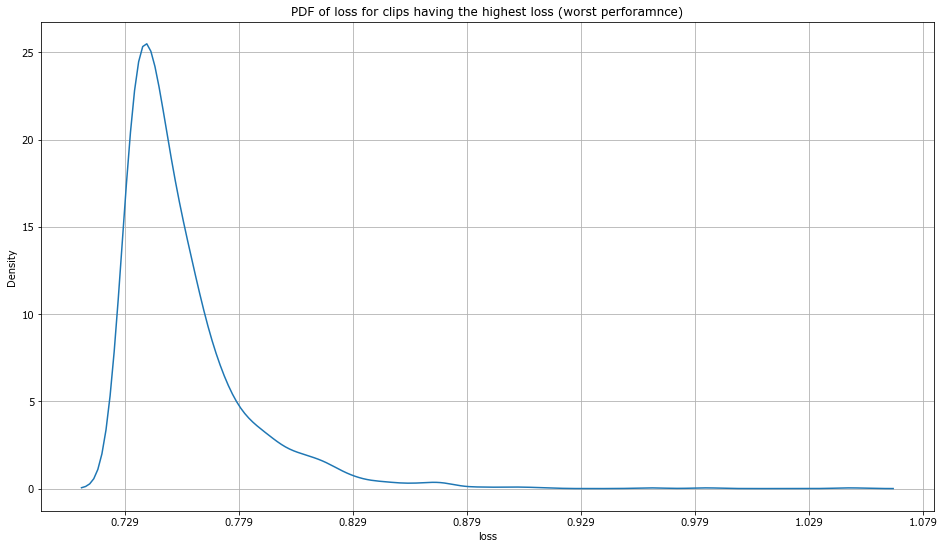

In [40]:
sns.kdeplot(df_worst_perf['loss'])
delta=0.05
plt.title('PDF of loss for clips having the highest loss (worst perforamnce)')
plt.xticks(np.arange(np.min(df_worst_perf['loss']), np.max(df_worst_perf['loss']) + delta, delta))
plt.grid()
plt.show()

**Obervation: There are few clips which have very high loss but most of the clips have low loss (comparatively)**

### Analysis: Whether the number of labels play a key role in determining the loss?
This is possible since it's a multilabel classification problem and seems logical because if there are more number of labels per clip, it becomes hard for the model to predict all the categories and hence these are likely to have a high loss.

In [41]:
def count_labels(s):
    return len(s.split(','))

In [42]:
df_best_perf['count_labels']  = df_best_perf['labels'].map(lambda x: count_labels(x))
df_med_perf['count_labels']   = df_med_perf['labels'].map(lambda x: count_labels(x))
df_worst_perf['count_labels'] = df_worst_perf['labels'].map(lambda x: count_labels(x))

In [43]:
df_best_perf['count_labels'].value_counts()/len(df_best_perf)*100

1    88.593844
2     9.716355
3     1.689801
Name: count_labels, dtype: float64

In [44]:
df_med_perf['count_labels'].value_counts()/len(df_med_perf)*100

1    93.478261
2     5.797101
3     0.724638
Name: count_labels, dtype: float64

In [45]:
df_worst_perf['count_labels'].value_counts()/len(df_worst_perf)*100

1    75.618588
2    22.329511
3     1.750151
4     0.241400
6     0.060350
Name: count_labels, dtype: float64

### Observation: As the number of labels per clip increase, the performance degrades

### Analysis: Finding the top 10 most freq. occurring labels along with the number of clips for each label

In [46]:
best_perf_labels_count_dict = {}
for row in list(df_best_perf['labels']):
    for lab in row.split(','):
        if lab in best_perf_labels_count_dict:
            best_perf_labels_count_dict[lab]+=1
        else:
            best_perf_labels_count_dict[lab]=1

In [47]:
best_perf_labels_count_dict = dict(sorted(best_perf_labels_count_dict.items(), key=lambda item: item[1], reverse=True))

In [48]:
#Top 10 categories with the least misclassified points
c=0
for k, v in best_perf_labels_count_dict.items():
    if c==10: break
    print(k, ":", v)
    c+=1

harmonica : 67
strum : 66
acoustic_guitar : 65
bass_guitar : 60
bark : 57
skateboard : 56
male_singing : 53
hi-hat : 51
toilet_flush : 46
tick-tock : 46


In [49]:
med_perf_labels_count_dict = {}
for row in list(df_med_perf['labels']):
    for lab in row.split(','):
        if lab in med_perf_labels_count_dict:
            med_perf_labels_count_dict[lab]+=1
        else:
            med_perf_labels_count_dict[lab]=1

In [50]:
med_perf_labels_count_dict = dict(sorted(med_perf_labels_count_dict.items(), key=lambda item: item[1], reverse=True))

In [51]:
#Top 10 categories with the average misclassified points
c=0
for k, v in med_perf_labels_count_dict.items():
    if c==10: break
    print(k, ":", v)
    c+=1

computer_keyboard : 44
zipper_(clothing) : 42
microwave_oven : 40
female_singing : 39
finger_snapping : 38
chewing_and_mastication : 38
knock : 37
traffic_noise_and_roadway_noise : 36
waves_and_surf : 36
hiss : 36


In [52]:
worst_perf_labels_count_dict = {}
for row in list(df_worst_perf['labels']):
    for lab in row.split(','):
        if lab in worst_perf_labels_count_dict:
            worst_perf_labels_count_dict[lab]+=1
        else:
            worst_perf_labels_count_dict[lab]=1

In [53]:
worst_perf_labels_count_dict = dict(sorted(worst_perf_labels_count_dict.items(), key=lambda item: item[1], reverse=True))

In [54]:
#Top 10 categories with the most misclassified points
c=0
for k, v in worst_perf_labels_count_dict.items():
    if c==10: break
    print(k, ":", v)
    c+=1

squeak : 71
sink_(filling_or_washing) : 62
bathtub_(filling_or_washing) : 58
water_tap_and_faucet : 57
slam : 56
cupboard_open_or_close : 54
dishes_and_pots_and_pans : 52
motorcycle : 50
cutlery_and_silverware : 49
drawer_open_or_close : 48


#### Observation: There are few labels (acoustic guitar, strum) for which nearly all the clips having these labels have low loss, while there are few labels (squeak) for which nearly all the clips have high loss.

### Analysis: Does the duration of the clip determines loss?

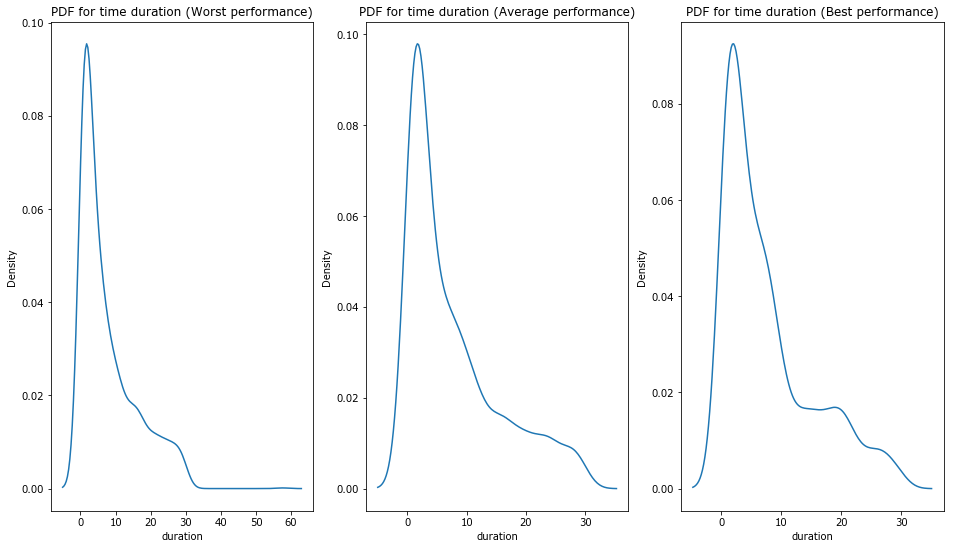

In [55]:
#Ref: https://stackoverflow.com/questions/41384040/subplot-for-seaborn-boxplot
#Ref: https://stackoverflow.com/questions/25239933/how-to-add-title-to-subplots-in-matplotlib

f, axes = plt.subplots(1, 3)

sns.kdeplot(df_worst_perf['duration'], ax=axes[0])
axes[0].title.set_text('PDF for time duration (Worst performance)')

sns.kdeplot(df_med_perf['duration'],   ax=axes[1])
axes[1].title.set_text('PDF for time duration (Average performance)')

sns.kdeplot(df_best_perf['duration'],  ax=axes[2])
axes[2].title.set_text('PDF for time duration (Best performance)')

**Observation: All the clips which are of long duration have high loss, this maybe true because, if the duration is very long, there can be many different sounds in the clip and the model can't predict all of them accurately leading to a higher loss**

### Visualization of most frequently misclassified points

In [56]:
predictions_sigmoid = 1/(1+np.exp(-predictions))

In [57]:
c=0
freq_misclassified_labels=[]
for lab in worst_perf_labels_count_dict.keys():
    freq_misclassified_labels.append(lab)
    c+=1
    if c==10: break

In [58]:
freq_misclassified_labels

['squeak',
 'sink_(filling_or_washing)',
 'bathtub_(filling_or_washing)',
 'water_tap_and_faucet',
 'slam',
 'cupboard_open_or_close',
 'dishes_and_pots_and_pans',
 'motorcycle',
 'cutlery_and_silverware',
 'drawer_open_or_close']

In [59]:
def get_df_for_a_label(label):
    df_new = df_train[df_train['labels'].str.contains(label)]
    return df_new

### Class label: Squeak

In [60]:
df_squeak = get_df_for_a_label('squeak')

In [61]:
df_squeak.head()

fname  labels  duration      loss  predicted_label
3910  c8c7b116.wav  squeak  4.675918  0.720902           squeak
4927  fdbb5cd6.wav  squeak  0.626939  0.724325        screaming
843   2c58c81e.wav  squeak  0.835306  0.724424  chirp_and_tweet
2643  8870cc59.wav  squeak  0.648027  0.725884           squeak
3300  ab0b6d6d.wav  squeak  0.413900  0.734696             drip

In [62]:
df_squeak['predicted_label'].value_counts()[:5]

walk_and_footsteps        14
microwave_oven            10
slam                       9
electric_guitar            4
cupboard_open_or_close     4
Name: predicted_label, dtype: int64

Many points which are of motorcycle are classified as walk_and_footsteps and microwave_oven, the reason can be all these sounds are low amplitude sounds. <br>
Let's try to investigate why this happened

In [101]:
df_actual_squeak_classified_walk_and_footsteps = df_squeak[df_squeak['predicted_label'] == 'walk_and_footsteps']

In [102]:
df_actual_squeak_classified_walk_and_footsteps

fname                         labels   duration      loss  \
952   3218a0e2.wav                         squeak   8.884649  0.736150   
4050  d15f0b6a.wav      squeak,walk_and_footsteps   9.593741  0.740821   
432   1797235d.wav      squeak,walk_and_footsteps   4.037347  0.757410   
4736  f429c7f1.wav      squeak,walk_and_footsteps   8.008141  0.757590   
918   30a466c4.wav      squeak,walk_and_footsteps   2.602676  0.762645   
3854  c59dcf65.wav      squeak,walk_and_footsteps   4.691111  0.776686   
2046  68ec3b17.wav      squeak,walk_and_footsteps  12.681383  0.776707   
1546  5050c839.wav      squeak,walk_and_footsteps   7.487415  0.777550   
4134  d601c5ca.wav      squeak,walk_and_footsteps   6.803946  0.779223   
951   321564ac.wav      squeak,walk_and_footsteps   5.940023  0.780827   
3269  a92f3c97.wav                    squeak,slam   6.178299  0.785477   
4209  da15e94b.wav                    squeak,slam   8.452063  0.794701   
259   0e0d4cf6.wav      squeak,walk_and_footsteps   9.380862  0.796840   
3936  ca5eebba.wav  squeak,cupboard_open_or_close   9.409932  0.883128   

         predicted_label  
952   walk_and_footsteps  
4050  walk_and_footsteps  
432   walk_and_footsteps  
4736  walk_and_footsteps  
918   walk_and_footsteps  
3854  walk_and_footsteps  
2046  walk_and_footsteps  
1546  walk_and_footsteps  
4134  walk_and_footsteps  
951   walk_and_footsteps  
3269  walk_and_footsteps  
4209  walk_and_footsteps  
259   walk_and_footsteps  
3936  walk_and_footsteps

#### It can be clearly seen that the label also contained "walk_and_footsteps" along with "squeak" and hence the model predicted the label "walk_and_footsteps" with highest prob., which is reasonable since both the labels are present. <br> <br> Let's see if it classified "squeak" as the 2nd/3rd most probable label

In [103]:
# Finding the top 5 class labels along with their probabilities for each datapoint containing "squeak" in its class label
indices = df_actual_squeak_classified_walk_and_footsteps.index
pred_squeak = [predictions_sigmoid[i] for i in indices]

sorted_indices = []
for i in range(len(pred_squeak)):
    sorted_indices.append(np.argsort(pred_squeak[i]))
    
top_5_indices = [sorted_indices[i][-5:][::-1] for i in range(len(sorted_indices))]

top_5_labels = []
for i in range(len(top_5_indices)):
    top_5_labels.append([label_dict[i] for i in top_5_indices[i]])
    
top_5_prob = []
for i in range(len(top_5_indices)):
    top_5_prob.append([pred_squeak[i][j] for j in top_5_indices[i]])

#### Sample Clip 1

In [71]:
for i in range(5):
    print(f"{top_5_labels[0][i]} : {round(top_5_prob[0][i], 3)}")

walk_and_footsteps : 0.061
squeak : 0.056
writing : 0.03
sneeze : 0.028
printer : 0.023


#### Sample Clip 2

In [72]:
for i in range(5):
    print(f"{top_5_labels[1][i]} : {round(top_5_prob[1][i], 3)}")

walk_and_footsteps : 0.412
run : 0.244
zipper_(clothing) : 0.113
squeak : 0.098
chewing_and_mastication : 0.061


#### Sample Clip 3

In [73]:
for i in range(5):
    print(f"{top_5_labels[2][i]} : {round(top_5_prob[2][i], 3)}")

walk_and_footsteps : 0.273
slam : 0.177
run : 0.106
traffic_noise_and_roadway_noise : 0.066
squeak : 0.051


**Observation: All of the 3 sample clips contain Squeak in the top 5 labels, hence, the model is able to identify it, however with difficulty. This is okay, since squeak is a difficult sound for even humans to hear**

### Class label: Sink

In [74]:
df_sink = get_df_for_a_label('sink')

In [75]:
df_sink.head()

fname                                          labels   duration  \
3458  b2f01c02.wav  sink_(filling_or_washing),water_tap_and_faucet  13.394853   
2163  6fa75c1d.wav  sink_(filling_or_washing),water_tap_and_faucet   8.769229   
3256  a8abe3d7.wav  sink_(filling_or_washing),water_tap_and_faucet  14.953288   
4005  ce701343.wav  sink_(filling_or_washing),water_tap_and_faucet   9.691474   
3151  a3986e00.wav  sink_(filling_or_washing),water_tap_and_faucet  11.321134   

          loss       predicted_label  
3458  0.697632  water_tap_and_faucet  
2163  0.706521  water_tap_and_faucet  
3256  0.708838  water_tap_and_faucet  
4005  0.711589  water_tap_and_faucet  
3151  0.714527  water_tap_and_faucet

In [76]:
df_sink['predicted_label'].value_counts()[:5]

water_tap_and_faucet    32
toilet_flush            17
drip                     8
fill_(with_liquid)       6
gurgling                 3
Name: predicted_label, dtype: int64

**All these sounds are very similar to each other and many times also present in the actual class labels, so, the model is not making any mistake here**

### Visualizing the top 10 points with the highest loss

In [77]:
df_train['count_labels']  = df_train['labels'].map(lambda x: count_labels(x))

In [78]:
top_10_points_having_highest_loss = df_train[-10:]
top_10_points_having_highest_loss

fname                                             labels  \
2520  8238e311.wav  trickle_and_dribble,bathtub_(filling_or_washin...   
2890  95c7fe22.wav  fill_(with_liquid),bathtub_(filling_or_washing...   
3936  ca5eebba.wav                      squeak,cupboard_open_or_close   
4535  eac33596.wav                        applause,harmonica,cheering   
3980  cce07823.wav  fill_(with_liquid),sink_(filling_or_washing),w...   
3731  c02b4176.wav  cutlery_and_silverware,dishes_and_pots_and_pan...   
2882  9579b1c8.wav                        electric_guitar,bass_guitar   
1148  3c13f5cd.wav                                  bark,cricket,buzz   
140   07b01fb0.wav                            applause,crowd,cheering   
2955  99580c64.wav  applause,dishes_and_pots_and_pans,crowd,cheeri...   

       duration      loss     predicted_label  count_labels  
2520   6.157234  0.871012            gurgling             4  
2890  23.394104  0.871273  fill_(with_liquid)             3  
3936   9.409932  0.883128  walk_and_footsteps             2  
4535  22.752653  0.887518            applause             3  
3980  25.985850  0.898334  fill_(with_liquid)             4  
3731   1.031270  0.902003           tick-tock             3  
2882   9.959683  0.911622         bass_guitar             2  
1148  22.963673  0.959285        toilet_flush             3  
140    8.294989  0.984152           screaming             3  
2955  21.437506  1.047204               crowd             6

In [79]:
points_with_highest_loss_fnames = list(top_10_points_having_highest_loss['fname'])

indices = top_10_points_having_highest_loss.index
pred_high_loss = [predictions_sigmoid[i] for i in indices]

sorted_indices = []
for i in range(len(pred_high_loss)):
    sorted_indices.append(np.argsort(pred_high_loss[i]))
    
top_5_indices = [sorted_indices[i][-5:][::-1] for i in range(len(sorted_indices))]

top_5_labels = []
for i in range(len(top_5_indices)):
    top_5_labels.append([label_dict[i] for i in top_5_indices[i]])
    
top_5_prob = []
for i in range(len(top_5_indices)):
    top_5_prob.append([pred_high_loss[i][j] for j in top_5_indices[i]])

In [81]:
train_data_path = r'F:\Jupyter_Notebook\AAIC\Assignments\Case_Study_2_Freesound_Audio_Tagging\train_data'

### Clip 1

In [82]:
filename = train_data_path + '\\' + points_with_highest_loss_fnames[-1]
IPython.display.Audio(filename = filename)

In [92]:
print("Actual class labels -> \n")
for label in top_10_points_having_highest_loss[-1:].labels.values[0].split(','):
    print(label)
    
print("\n\nPredicted class labels -> \n")
for i in range(5):
    print(f"{top_5_labels[-1][i]} : {round(top_5_prob[-1][i], 3)}")

Actual class labels -> 

applause
dishes_and_pots_and_pans
crowd
cheering
clapping
child_speech_and_kid_speaking


Predicted class labels -> 

crowd : 0.492
applause : 0.364
cheering : 0.12
clapping : 0.02
screaming : 0.013


Observation: The clip consists of multiple sounds like cheering, applausing. The model predicts many of the labels correctly. But, there is a lot of noise and hence the nuance sounds can't be heard properly.

### Clip 2

In [84]:
filename = train_data_path + '\\' + points_with_highest_loss_fnames[-2]
IPython.display.Audio(filename = filename)

In [93]:
print("Actual class labels -> \n")
for label in top_10_points_having_highest_loss[-2:].labels.values[0].split(','):
    print(label)
    
print("\n\nPredicted class labels -> \n")
for i in range(5):
    print(f"{top_5_labels[-2][i]} : {round(top_5_prob[-2][i], 3)}")

Actual class labels -> 

applause
crowd
cheering


Predicted class labels -> 

screaming : 0.301
drip : 0.044
raindrop : 0.023
male_speech_and_man_speaking : 0.017
electric_guitar : 0.013


Observation: The model identifies "screaming" as one of the class label which is also there in the clip. However, it is not able to identify the other labels like "applause" which are clearly audible in the clip. 

### Clip 3

In [94]:
filename = train_data_path + '\\' + points_with_highest_loss_fnames[-3]
IPython.display.Audio(filename = filename)

In [96]:
print("Actual class labels -> \n")
for label in top_10_points_having_highest_loss[-3:].labels.values[0].split(','):
    print(label)
    
print("\n\nPredicted class labels -> \n")
for i in range(5):
    print(f"{top_5_labels[-3][i]} : {round(top_5_prob[-3][i], 3)}")

Actual class labels -> 

bark
cricket
buzz


Predicted class labels -> 

toilet_flush : 0.11
hiss : 0.101
bathtub_(filling_or_washing) : 0.058
meow : 0.045
chewing_and_mastication : 0.041


Observation: The model predicts the "hiss" sound which is somewhat there in the clip, but rest of the sounds are nowhere in the clip. Hence, the model makes a clear mistake here.

### Clip 4

In [97]:
filename = train_data_path + '\\' + points_with_highest_loss_fnames[-4]
IPython.display.Audio(filename = filename)

In [99]:
print("Actual class labels -> \n")
for label in top_10_points_having_highest_loss[-4:].labels.values[0].split(','):
    print(label)
    
print("\n\nPredicted class labels -> \n")
for i in range(5):
    print(f"{top_5_labels[-4][i]} : {round(top_5_prob[-4][i], 3)}")

Actual class labels -> 

electric_guitar
bass_guitar


Predicted class labels -> 

bass_guitar : 0.174
acoustic_guitar : 0.009
chink_and_clink : 0.008
drip : 0.003
strum : 0.002


Observation: The model identifies "bass_guitar" correctly, a similar sounding sound is "electric_guitar" which can't be identified by the model. This mistake is okay and can easily be committed by a human also.

### Visualizing the top 10 points with the least loss

In [100]:
top_10_points_having_least_loss = df_train[:10]
top_10_points_having_least_loss

fname                 labels  duration      loss  \
4375  e20242b9.wav  acoustic_guitar,strum  7.418435  0.510646   
1062  378b39f6.wav  acoustic_guitar,strum  7.279932  0.512213   
2174  7048c84b.wav  acoustic_guitar,strum  7.910408  0.517574   
3592  b9af9256.wav  acoustic_guitar,strum  7.187800  0.521099   
2038  689fe63b.wav  acoustic_guitar,strum  7.499456  0.521612   
1847  5fe5138b.wav  acoustic_guitar,strum  9.004218  0.524873   
4799  f7686141.wav  acoustic_guitar,strum  5.327619  0.525985   
3310  abbf4f95.wav  acoustic_guitar,strum  9.928957  0.526718   
3937  ca74df21.wav  acoustic_guitar,strum  8.171791  0.527685   
1633  54940c5c.wav  acoustic_guitar,strum  6.354966  0.528694   

      predicted_label  count_labels  
4375  acoustic_guitar             2  
1062  acoustic_guitar             2  
2174  acoustic_guitar             2  
3592  acoustic_guitar             2  
2038  acoustic_guitar             2  
1847  acoustic_guitar             2  
4799  acoustic_guitar             2  
3310  acoustic_guitar             2  
3937  acoustic_guitar             2  
1633  acoustic_guitar             2

**Observations:  <br>The model classifies each point correctly, this can be because the sound of guitar is quite disticntive and high pitched from the other environmental sounds. <br><br>Also, inspite of the fact that these are of different durations, which means, the model is capable of correctly classifying clips of long durations when the number of labels per clip is less and the sounds are less ambigous.**

## Conclusions:
1. The model performs good on majority of the points. There are few points for which the loss is high (observation made from the fat tails of the normal distribution of the losses). <br><br>
2. The model performs good on clips with single label per clip and where the clip has low to moderate background noise. <br><br>
3. The model fails to identify all the correct labels when the number of labels per clip are high (>2) and the clips contain various very similar sounds like water_tap_and_faucet, toilet_flush, drip, fill_(with_liquid) etc.<br><br>
4. The model also can't perform well if the clip is too short (1-2 seconds) as even a human can't detect the environmental sound present in such a short clip. The model sometimes has problems in identifying very long clips (>15 seconds) also where there are too many labels are background noise. The model predicts only the labels which can be distinctly heard and fails to identify the nuanced sounds. This behaviour is also similar to human behaviour. <br><br>
5. Ideally, the model performs best when the clip is of a moderate duration and consists of a 1 label with less background noise. Increasing the number of labels does not cause a problem unless the background noise is so high that the nuance labels' sounds are unable to be heard. Also, since all these sounds are environmental sounds, it becomes tough to correctly classify very similar sounds even for humans. The model behaves almost comparable to a human in identifying most of the clips.